In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras import models
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

Using TensorFlow backend.


In [16]:
def generate_prediction(file_path, model_name):
    
    # read data from the file
    dataset = pd.read_csv(file_path)
    # extracting a single feature
    X0 = dataset.BIDASKIMBALANCE
    # split into train and test
    train, test = split_dataset3(X0.values)
    # evaluate model and get scores
    n_input = 60
    score, scores, predictions = evaluate_model(train, test, n_input, model_name)
    # summarize scores
    summarize_scores('Best Trained Model', score, scores)
    # plot scores
    days = ['LS1', 'LS2', 'LS3', 'LS4', 'LS5', 'LS6', 'LS7','LS8','LS9','LS10','LS11', 'LS12',
            'LS13', 'LS14', 'LS15', 'LS16', 'LS17','LS18','LS19','LS20']
    pyplot.figure(figsize=(10,5))
    pyplot.plot(days, scores, marker='o', label='Best trained')
    pyplot.legend()
    pyplot.show()
    # return predictions
    return predictions
    

In [3]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [12]:
# split a univariate dataset into train/test sets
def split_dataset3(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[:60], data[60:(max_steps*20)]
	# restructure into windows of 20-step data
	train = rolling_window(train, 20)
	test = rolling_window(test, 20)
	# place it in a dataframe
	trainDF = pd.DataFrame(data=train)
	testDF = pd.DataFrame(data=test)
	# name columns  
	cols_train = trainDF.columns.tolist()
	cols_test = testDF.columns.tolist()
	# rearrange columns      
	cols_train = cols_train[::-1]
	cols_test = cols_test[::-1]
	# rearrange dataframe   
	trainDF = trainDF[cols_train] 
	testDF = testDF[cols_test]
	# extract values
	train =trainDF.values
	test = testDF.values
	# reshape values    
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [5]:
# split a univariate dataset into train/test sets
def split_dataset3(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[14940:15000], data[15000:30000]
	# restructure into windows of 20-step data
	train = np.array(np.split(train, len(train)/20))
	test = np.array(np.split(test, len(test)/20))
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [6]:
# split a univariate dataset into train/test sets
def split_dataset3(data):
	# split into standard weeks
	max_steps = int(len(data)/20)    
	train, test = data[0:60], data[60:(max_steps*20)]
	# restructure into windows of 20-step data
	train = np.array(np.split(train, len(train)/20))
	test = np.array(np.split(test, len(test)/20))
	train = train.reshape(train.shape[0], train.shape[1], 1) # 1 being the number of features [samples,timesteps, features]
	test = test.reshape(test.shape[0],test.shape[1], 1) # 1 being the number of features [samples,timesteps, features]    
	return train, test

In [8]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [9]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [10]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [14]:
# evaluate a single model
def evaluate_model(train, test, n_input, model_name):
	# load model
	model = models.load_model(model_name)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :], predictions)
#	score, scores = 0, 0
	return score, scores, predictions

In [23]:
int(50/20)

2

In [17]:
file_path = 'trainData_set1.csv'
model_name = "lstm2.hdf5"

In [20]:
df0 = pd.read_csv(file_path)

In [21]:
df0.head()

Unnamed: 0  TRADEDATE          TIME   BID  BIDSIZE  ASK  ASKSIZE  \
0           0   20170703  10:59:32.944  9.55  1220700  9.6    11700   
1           1   20170703  10:59:35.938  9.55  1220700  9.6    12000   
2           2   20170703  10:59:36.850  9.55  1220700  9.6   111900   
3           3   20170703  10:59:37.936  9.55  1220700  9.6   113600   
4           4   20170703  10:59:37.936  9.55  1220700  9.6   113500   

   BIDASKIMBALANCE  OPEN TICKDIR  ...  ASKTRADE3  LASTTICKDIR  LASTTICKDIR1  \
0         0.981013  9.55    FLAT  ...          0         FLAT          FLAT   
1         0.980531  9.55    FLAT  ...          0         FLAT          FLAT   
2         0.832058  9.55    FLAT  ...          0         FLAT          FLAT   
3         0.829723  9.55    FLAT  ...          0         FLAT          FLAT   
4         0.829861  9.55    FLAT  ...          0         FLAT          FLAT   

   LASTTICKDIR2  LASTTICKDIR3  LASTTICKDURATION  LASTTICKDURATION1  \
0          FLAT          FLAT                 0                  0   
1          FLAT          FLAT                 0                  0   
2          FLAT          FLAT                 0                  0   
3          FLAT          FLAT                 0                  0   
4          FLAT          FLAT                 0                  0   

   LASTTICKDURATION2  LASTTICKDURATION3  MARKETTIME  
0                  0                  0           0  
1                  0                  0           2  
2                  0                  0           3  
3                  0                  0           4  
4                  0                  0           4  

[5 rows x 44 columns]

In [22]:
df1 = df0[:200]

In [23]:
df1.to_csv('small_set.csv')

In [24]:
file_path = 'small_set.csv'
model_name = "lstm2.hdf5"

Best Trained Model: [0.028] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


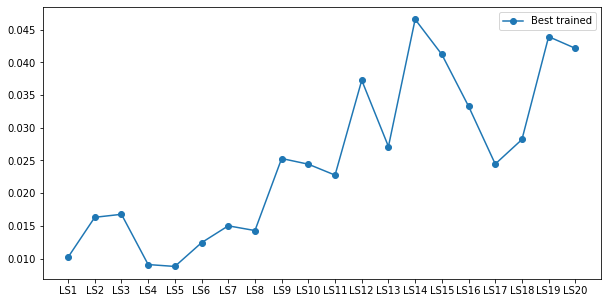

In [25]:
predictions = generate_prediction(file_path, model_name)

In [26]:
predictions.shape

(121, 20)

In [27]:
predictionDF = pd.DataFrame(data=predictions, columns=['LS1', 'LS2', 'LS3', 'LS4', 'LS5', 'LS6', 'LS7','LS8',
                                                       'LS9','LS10','LS11', 'LS12',
            'LS13', 'LS14', 'LS15', 'LS16', 'LS17','LS18','LS19','LS20'])

In [28]:
predictionDF.head()

LS1       LS2       LS3       LS4       LS5       LS6       LS7  \
0  0.140766  0.124149  0.125473  0.136805  0.134344  0.129678  0.128098   
1  0.146086  0.130677  0.131586  0.142882  0.141270  0.135821  0.133988   
2  0.147590  0.132395  0.133228  0.144506  0.143054  0.137469  0.135536   
3  0.146522  0.131436  0.132240  0.143610  0.142243  0.136578  0.134729   
4  0.149591  0.134682  0.135488  0.146712  0.145609  0.139774  0.137672   

        LS8       LS9      LS10      LS11      LS12      LS13      LS14  \
0  0.130044  0.117232  0.116028  0.119410  0.101554  0.111575  0.094803   
1  0.135891  0.122660  0.122305  0.125365  0.107755  0.117841  0.100555   
2  0.137406  0.124109  0.123883  0.126883  0.109345  0.119408  0.101971   
3  0.136693  0.123310  0.123264  0.126279  0.108596  0.118874  0.101429   
4  0.139522  0.126096  0.126125  0.129053  0.111541  0.121707  0.103926   

       LS15      LS16      LS17      LS18      LS19      LS20  
0  0.103492  0.108475  0.113229  0.110064  0.091811  0.096209  
1  0.108837  0.114549  0.119407  0.116035  0.097804  0.101844  
2  0.110133  0.116046  0.120935  0.117510  0.099291  0.103254  
3  0.109820  0.115559  0.120387  0.117100  0.098765  0.102859  
4  0.112051  0.118219  0.123124  0.119679  0.101383  0.105341

In [30]:
def struct_20step_predict(predictions):
    #convert array of prediction into a dataframe for 5 step forecasting
    predictionDF = pd.DataFrame(data=predictions, columns=['LS1', 'LS2', 'LS3', 'LS4', 'LS5', 'LS6', 'LS7','LS8',
                                                       'LS9','LS10','LS11', 'LS12',
            'LS13', 'LS14', 'LS15', 'LS16', 'LS17','LS18','LS19','LS20'])
    # place max limit of 1
    predictionDF1 = pd.DataFrame(np.where(predictionDF > 1, 1, predictionDF),columns=['LS1', 'LS2', 'LS3', 'LS4',
                                                                                      'LS5', 'LS6', 'LS7','LS8',
                                                       'LS9','LS10','LS11', 'LS12',
            'LS13', 'LS14', 'LS15', 'LS16', 'LS17','LS18','LS19','LS20'])
    # place min limit of -1 
    predictionDF2 = pd.DataFrame(np.where(predictionDF1 < -1, -1, predictionDF1),columns=['LS1', 'LS2', 'LS3', 'LS4',
                                                                                          'LS5', 'LS6', 'LS7','LS8',
                                                       'LS9','LS10','LS11', 'LS12',
            'LS13', 'LS14', 'LS15', 'LS16', 'LS17','LS18','LS19','LS20'])
    # return dataframe
    return predictionDF2

In [31]:
predictionDF = struct_20step_predict(predictions)

In [32]:
predictionDF.describe()

LS1         LS2         LS3         LS4         LS5         LS6  \
count  121.000000  121.000000  121.000000  121.000000  121.000000  121.000000   
mean     0.183080    0.173404    0.171306    0.183617    0.183098    0.174403   
std      0.016651    0.019657    0.017891    0.018687    0.018748    0.017331   
min      0.140766    0.124149    0.125473    0.136805    0.134344    0.129678   
25%      0.167355    0.154513    0.154340    0.165559    0.165376    0.157946   
50%      0.191983    0.183678    0.180753    0.193504    0.193192    0.183547   
75%      0.196599    0.189347    0.185777    0.198599    0.198027    0.188318   
max      0.202874    0.197361    0.192909    0.205933    0.204990    0.194880   

              LS7         LS8         LS9        LS10        LS11        LS12  \
count  121.000000  121.000000  121.000000  121.000000  121.000000  121.000000   
mean     0.170485    0.170714    0.158278    0.158678    0.159893    0.144397   
std      0.016614    0.015709    0.016194    0.016629    0.015621    0.016523   
min      0.128098    0.130044    0.117232    0.116028    0.119410    0.101554   
25%      0.154447    0.155747    0.142815    0.142526    0.144981    0.128668   
50%      0.179333    0.179279    0.166829    0.167880    0.168369    0.153309   
75%      0.183789    0.183165    0.171301    0.171797    0.172301    0.157529   
max      0.190001    0.189417    0.177697    0.178462    0.178600    0.164019   

             LS13        LS14        LS15        LS16        LS17        LS18  \
count  121.000000  121.000000  121.000000  121.000000  121.000000  121.000000   
mean     0.154304    0.134027    0.139197    0.146806    0.155229    0.150680   
std      0.016278    0.015201    0.013801    0.014251    0.016088    0.015784   
min      0.111575    0.094803    0.103492    0.108475    0.113229    0.110064   
25%      0.138965    0.119500    0.125988    0.133519    0.140010    0.135536   
50%      0.163555    0.142549    0.146901    0.154834    0.164166    0.159623   
75%      0.166883    0.145876    0.149880    0.157824    0.167894    0.162971   
max      0.173183    0.152141    0.155657    0.163569    0.174250    0.169279   

             LS19        LS20  
count  121.000000  121.000000  
mean     0.134152    0.135542  
std      0.016952    0.015391  
min      0.091811    0.096209  
25%      0.117497    0.120784  
50%      0.143580    0.144144  
75%      0.147565    0.147641  
max      0.154656    0.154007

In [33]:
df0 = pd.read_csv('small_set.csv')

In [35]:
df1 = df0.join(predictionDF)

In [39]:
df1.tail()

Unnamed: 0  Unnamed: 0.1  TRADEDATE          TIME  BID  BIDSIZE   ASK  \
195         195           195   20170703  11:13:12.960  9.5  3256300  9.55   
196         196           196   20170703  11:13:37.097  9.5  3356300  9.55   
197         197           197   20170703  11:13:40.341  9.5  3356300  9.55   
198         198           198   20170703  11:13:40.341  9.5  3356300  9.55   
199         199           199   20170703  11:13:40.954  9.5  3248000  9.55   

     ASKSIZE  BIDASKIMBALANCE  OPEN  ... LS11  LS12  LS13  LS14  LS15  LS16  \
195  2140000         0.206864  9.55  ...  NaN   NaN   NaN   NaN   NaN   NaN   
196  2140000         0.221294  9.55  ...  NaN   NaN   NaN   NaN   NaN   NaN   
197  2139900         0.221317  9.55  ...  NaN   NaN   NaN   NaN   NaN   NaN   
198  2134900         0.222429  9.55  ...  NaN   NaN   NaN   NaN   NaN   NaN   
199  2134900         0.206784  9.55  ...  NaN   NaN   NaN   NaN   NaN   NaN   

     LS17  LS18  LS19  LS20  
195   NaN   NaN   NaN   NaN  
196   NaN   NaN   NaN   NaN  
197   NaN   NaN   NaN   NaN  
198   NaN   NaN   NaN   NaN  
199   NaN   NaN   NaN   NaN  

[5 rows x 65 columns]

In [41]:
df1.to_csv('small_set2.csv')

In [43]:
def join_dataframe(file_path, predictionDF):
    
    #read initial dataframe
    df0 = pd.read_csv(file_path)
    # join dataframe
    df1 = df0.join(predictionDF)
    # save joined dataframe in tempfile
    df1.to_csv('tempfile_1.csv')
    print("20-step forecast saved in tempfile_1.csv")

In [44]:
file_path = 'small_set.csv'
model_name = "lstm2.hdf5"

In [45]:
def run_prediction_20(file_path, model_name):
    
    # run prediction function
    predictions = generate_prediction(file_path, model_name)
    # create prediction DF
    predictionDF = struct_20step_predict(predictions)
    # join dataframe
    join_dataframe(file_path, predictionDF)

Best Trained Model: [0.028] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


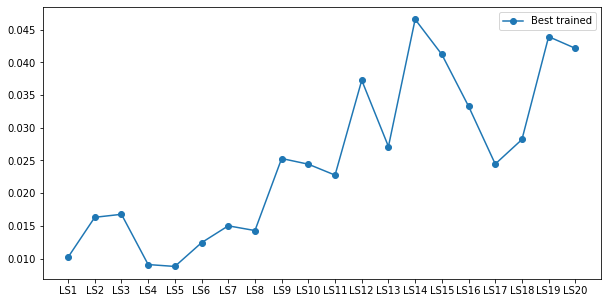

20-step forecast saved in tempfile_1.csv


In [46]:
run_prediction_20(file_path, model_name)

In [36]:
# read data from the file
dataset = pd.read_csv('trainData_set1.csv')
# extracting a single feature
X0 = dataset.BIDASKIMBALANCE

In [164]:
X1 = X0[15000:30000]

In [165]:
len(X0[15000:30000])

15000

In [38]:
750*20

15000

In [115]:
test = np.array(np.split(X1, len(X1)/20))

In [116]:
test.shape

(3, 20)

In [166]:
test = rolling_window(X1.values, 20)

In [167]:
test.shape

(14981, 20)

In [119]:
test = test.reshape(test.shape[0],test.shape[1], 1)

In [120]:
test.shape

(41, 20, 1)

In [168]:
testDF = pd.DataFrame(data=test,columns=['h19','h18', 'h17', 'h16', 'h15', 'h14', 'h13', 'h12',
                                                       'h11','h10','h9','h8', 'h7', 'h6', 'h5', 'h4',
                                                       'h3', 'h2','h1','c'])

In [169]:
testDF.head()

h19       h18       h17       h16       h15       h14       h13  \
0 -0.279228 -0.279011 -0.279554 -0.278469 -0.278252 -0.277602 -0.277479   
1 -0.279011 -0.279554 -0.278469 -0.278252 -0.277602 -0.277479 -0.277614   
2 -0.279554 -0.278469 -0.278252 -0.277602 -0.277479 -0.277614 -0.266873   
3 -0.278469 -0.278252 -0.277602 -0.277479 -0.277614 -0.266873 -0.266660   
4 -0.278252 -0.277602 -0.277479 -0.277614 -0.266873 -0.266660 -0.267427   

        h12       h11       h10        h9        h8        h7        h6  \
0 -0.277614 -0.266873 -0.266660 -0.267427 -0.265299 -0.261063 -0.260114   
1 -0.266873 -0.266660 -0.267427 -0.265299 -0.261063 -0.260114 -0.252927   
2 -0.266660 -0.267427 -0.265299 -0.261063 -0.260114 -0.252927 -0.252302   
3 -0.267427 -0.265299 -0.261063 -0.260114 -0.252927 -0.252302 -0.252165   
4 -0.265299 -0.261063 -0.260114 -0.252927 -0.252302 -0.252165 -0.252314   

         h5        h4        h3        h2        h1         c  
0 -0.252927 -0.252302 -0.252165 -0.252314 -0.252273 -0.252981  
1 -0.252302 -0.252165 -0.252314 -0.252273 -0.252981 -0.252484  
2 -0.252165 -0.252314 -0.252273 -0.252981 -0.252484 -0.254035  
3 -0.252314 -0.252273 -0.252981 -0.252484 -0.254035 -0.253619  
4 -0.252273 -0.252981 -0.252484 -0.254035 -0.253619 -0.254556

In [170]:
testDF.tail(20)

h19       h18       h17       h16       h15       h14       h13  \
14961 -0.050595 -0.062517 -0.062122 -0.050199 -0.050512 -0.107615 -0.107391   
14962 -0.062517 -0.062122 -0.050199 -0.050512 -0.107615 -0.107391 -0.051100   
14963 -0.062122 -0.050199 -0.050512 -0.107615 -0.107391 -0.051100 -0.051727   
14964 -0.050199 -0.050512 -0.107615 -0.107391 -0.051100 -0.051727 -0.108087   
14965 -0.050512 -0.107615 -0.107391 -0.051100 -0.051727 -0.108087 -0.107891   
14966 -0.107615 -0.107391 -0.051100 -0.051727 -0.108087 -0.107891 -0.052188   
14967 -0.107391 -0.051100 -0.051727 -0.108087 -0.107891 -0.052188 -0.052754   
14968 -0.051100 -0.051727 -0.108087 -0.107891 -0.052188 -0.052754 -0.066678   
14969 -0.051727 -0.108087 -0.107891 -0.052188 -0.052754 -0.066678 -0.066953   
14970 -0.108087 -0.107891 -0.052188 -0.052754 -0.066678 -0.066953 -0.067110   
14971 -0.107891 -0.052188 -0.052754 -0.066678 -0.066953 -0.067110 -0.067392   
14972 -0.052188 -0.052754 -0.066678 -0.066953 -0.067110 -0.067392 -0.075546   
14973 -0.052754 -0.066678 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431   
14974 -0.066678 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698   
14975 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263   
14976 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773   
14977 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446   
14978 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703   
14979 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848   
14980 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848 -0.074006   

            h12       h11       h10        h9        h8        h7        h6  \
14961 -0.051100 -0.051727 -0.108087 -0.107891 -0.052188 -0.052754 -0.066678   
14962 -0.051727 -0.108087 -0.107891 -0.052188 -0.052754 -0.066678 -0.066953   
14963 -0.108087 -0.107891 -0.052188 -0.052754 -0.066678 -0.066953 -0.067110   
14964 -0.107891 -0.052188 -0.052754 -0.066678 -0.066953 -0.067110 -0.067392   
14965 -0.052188 -0.052754 -0.066678 -0.066953 -0.067110 -0.067392 -0.075546   
14966 -0.052754 -0.066678 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431   
14967 -0.066678 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698   
14968 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263   
14969 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773   
14970 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446   
14971 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703   
14972 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848   
14973 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848 -0.074006   
14974 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848 -0.074006 -0.066310   
14975 -0.070773 -0.070446 -0.071703 -0.073848 -0.074006 -0.066310 -0.063614   
14976 -0.070446 -0.071703 -0.073848 -0.074006 -0.066310 -0.063614 -0.062610   
14977 -0.071703 -0.073848 -0.074006 -0.066310 -0.063614 -0.062610 -0.061043   
14978 -0.073848 -0.074006 -0.066310 -0.063614 -0.062610 -0.061043 -0.060442   
14979 -0.074006 -0.066310 -0.063614 -0.062610 -0.061043 -0.060442 -0.061708   
14980 -0.066310 -0.063614 -0.062610 -0.061043 -0.060442 -0.061708 -0.061550   

             h5        h4        h3        h2        h1         c  
14961 -0.066953 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698  
14962 -0.067110 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263  
14963 -0.067392 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773  
14964 -0.075546 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446  
14965 -0.061431 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703  
14966 -0.070698 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848  
14967 -0.071263 -0.070773 -0.070446 -0.071703 -0.073848 -0.074006  
14968 -0.070773 -0.070446 -0.071703 -0.073848 -0.074006 -0.066310  
14969 -0.070446 -0.071703 -0.073848 -0.074006 -0.066310 -0.063614  
14970 -0.071

In [171]:
cols = testDF.columns.tolist()

In [172]:
cols

['h19',
 'h18',
 'h17',
 'h16',
 'h15',
 'h14',
 'h13',
 'h12',
 'h11',
 'h10',
 'h9',
 'h8',
 'h7',
 'h6',
 'h5',
 'h4',
 'h3',
 'h2',
 'h1',
 'c']

In [173]:
cols = cols[::-1]

In [174]:
cols

['c',
 'h1',
 'h2',
 'h3',
 'h4',
 'h5',
 'h6',
 'h7',
 'h8',
 'h9',
 'h10',
 'h11',
 'h12',
 'h13',
 'h14',
 'h15',
 'h16',
 'h17',
 'h18',
 'h19']

In [175]:
testDF = testDF[cols] 

In [176]:
testDF.tail(20)

c        h1        h2        h3        h4        h5        h6  \
14961 -0.070698 -0.061431 -0.075546 -0.067392 -0.067110 -0.066953 -0.066678   
14962 -0.071263 -0.070698 -0.061431 -0.075546 -0.067392 -0.067110 -0.066953   
14963 -0.070773 -0.071263 -0.070698 -0.061431 -0.075546 -0.067392 -0.067110   
14964 -0.070446 -0.070773 -0.071263 -0.070698 -0.061431 -0.075546 -0.067392   
14965 -0.071703 -0.070446 -0.070773 -0.071263 -0.070698 -0.061431 -0.075546   
14966 -0.073848 -0.071703 -0.070446 -0.070773 -0.071263 -0.070698 -0.061431   
14967 -0.074006 -0.073848 -0.071703 -0.070446 -0.070773 -0.071263 -0.070698   
14968 -0.066310 -0.074006 -0.073848 -0.071703 -0.070446 -0.070773 -0.071263   
14969 -0.063614 -0.066310 -0.074006 -0.073848 -0.071703 -0.070446 -0.070773   
14970 -0.062610 -0.063614 -0.066310 -0.074006 -0.073848 -0.071703 -0.070446   
14971 -0.061043 -0.062610 -0.063614 -0.066310 -0.074006 -0.073848 -0.071703   
14972 -0.060442 -0.061043 -0.062610 -0.063614 -0.066310 -0.074006 -0.073848   
14973 -0.061708 -0.060442 -0.061043 -0.062610 -0.063614 -0.066310 -0.074006   
14974 -0.061550 -0.061708 -0.060442 -0.061043 -0.062610 -0.063614 -0.066310   
14975 -0.065368 -0.061550 -0.061708 -0.060442 -0.061043 -0.062610 -0.063614   
14976 -0.061825 -0.065368 -0.061550 -0.061708 -0.060442 -0.061043 -0.062610   
14977 -0.063104 -0.061825 -0.065368 -0.061550 -0.061708 -0.060442 -0.061043   
14978 -0.062822 -0.063104 -0.061825 -0.065368 -0.061550 -0.061708 -0.060442   
14979 -0.061804 -0.062822 -0.063104 -0.061825 -0.065368 -0.061550 -0.061708   
14980 -0.061196 -0.061804 -0.062822 -0.063104 -0.061825 -0.065368 -0.061550   

             h7        h8        h9       h10       h11       h12       h13  \
14961 -0.052754 -0.052188 -0.107891 -0.108087 -0.051727 -0.051100 -0.107391   
14962 -0.066678 -0.052754 -0.052188 -0.107891 -0.108087 -0.051727 -0.051100   
14963 -0.066953 -0.066678 -0.052754 -0.052188 -0.107891 -0.108087 -0.051727   
14964 -0.067110 -0.066953 -0.066678 -0.052754 -0.052188 -0.107891 -0.108087   
14965 -0.067392 -0.067110 -0.066953 -0.066678 -0.052754 -0.052188 -0.107891   
14966 -0.075546 -0.067392 -0.067110 -0.066953 -0.066678 -0.052754 -0.052188   
14967 -0.061431 -0.075546 -0.067392 -0.067110 -0.066953 -0.066678 -0.052754   
14968 -0.070698 -0.061431 -0.075546 -0.067392 -0.067110 -0.066953 -0.066678   
14969 -0.071263 -0.070698 -0.061431 -0.075546 -0.067392 -0.067110 -0.066953   
14970 -0.070773 -0.071263 -0.070698 -0.061431 -0.075546 -0.067392 -0.067110   
14971 -0.070446 -0.070773 -0.071263 -0.070698 -0.061431 -0.075546 -0.067392   
14972 -0.071703 -0.070446 -0.070773 -0.071263 -0.070698 -0.061431 -0.075546   
14973 -0.073848 -0.071703 -0.070446 -0.070773 -0.071263 -0.070698 -0.061431   
14974 -0.074006 -0.073848 -0.071703 -0.070446 -0.070773 -0.071263 -0.070698   
14975 -0.066310 -0.074006 -0.073848 -0.071703 -0.070446 -0.070773 -0.071263   
14976 -0.063614 -0.066310 -0.074006 -0.073848 -0.071703 -0.070446 -0.070773   
14977 -0.062610 -0.063614 -0.066310 -0.074006 -0.073848 -0.071703 -0.070446   
14978 -0.061043 -0.062610 -0.063614 -0.066310 -0.074006 -0.073848 -0.071703   
14979 -0.060442 -0.061043 -0.062610 -0.063614 -0.066310 -0.074006 -0.073848   
14980 -0.061708 -0.060442 -0.061043 -0.062610 -0.063614 -0.066310 -0.074006   

            h14       h15       h16       h17       h18       h19  
14961 -0.107615 -0.050512 -0.050199 -0.062122 -0.062517 -0.050595  
14962 -0.107391 -0.107615 -0.050512 -0.050199 -0.062122 -0.062517  
14963 -0.051100 -0.107391 -0.107615 -0.050512 -0.050199 -0.062122  
14964 -0.051727 -0.051100 -0.107391 -0.107615 -0.050512 -0.050199  
14965 -0.108087 -0.051727 -0.051100 -0.107391 -0.107615 -0.050512  
14966 -0.107891 -0.108087 -0.051727 -0.051100 -0.107391 -0.107615  
14967 -0.052188 -0.107891 -0.108087 -0.051727 -0.051100 -0.107391  
14968 -0.052754 -0.052188 -0.107891 -0.108087 -0.051727 -0.051100  
14969 -0.066678 -0.052754 -0.052188 -0.107891 -0.108087 -0.051727  
14970 -0.06695

In [177]:
predictionDF.tail(20)

s1        s2        s3        s4        s5        s6        s7  \
14961 -0.027601 -0.056140 -0.050870 -0.028437 -0.044762 -0.040988 -0.035988   
14962 -0.031531 -0.059810 -0.054563 -0.032028 -0.048639 -0.044471 -0.039394   
14963 -0.036912 -0.064990 -0.059603 -0.037065 -0.053625 -0.049263 -0.044042   
14964 -0.038661 -0.066551 -0.061231 -0.038648 -0.055519 -0.050793 -0.045464   
14965 -0.041454 -0.069118 -0.063803 -0.041229 -0.058351 -0.053228 -0.047675   
14966 -0.051100 -0.078641 -0.072817 -0.050451 -0.066892 -0.061755 -0.055847   
14967 -0.064077 -0.091638 -0.084788 -0.062794 -0.077648 -0.073173 -0.066989   
14968 -0.054394 -0.082208 -0.075738 -0.053673 -0.068728 -0.064611 -0.058676   
14969 -0.040412 -0.068457 -0.062877 -0.040571 -0.056939 -0.052315 -0.046605   
14970 -0.049004 -0.076900 -0.070806 -0.048678 -0.064324 -0.059869 -0.053875   
14971 -0.060292 -0.088130 -0.081122 -0.059301 -0.073321 -0.069722 -0.063569   
14972 -0.048209 -0.076403 -0.069857 -0.047946 -0.062292 -0.059063 -0.053350   
14973 -0.030681 -0.059233 -0.053841 -0.031591 -0.047617 -0.043707 -0.038426   
14974 -0.034699 -0.063065 -0.057612 -0.035330 -0.051384 -0.047261 -0.041873   
14975 -0.040007 -0.068262 -0.062560 -0.040342 -0.056024 -0.051966 -0.046444   
14976 -0.040543 -0.068776 -0.063070 -0.040852 -0.056547 -0.052441 -0.046899   
14977 -0.041205 -0.069400 -0.063687 -0.041479 -0.057178 -0.053016 -0.047441   
14978 -0.042053 -0.070213 -0.064468 -0.042290 -0.057939 -0.053749 -0.048131   
14979 -0.043099 -0.071228 -0.065415 -0.043291 -0.058807 -0.054646 -0.048985   
14980 -0.040462 -0.068622 -0.062999 -0.040841 -0.056671 -0.052314 -0.046661   

             s8        s9       s10       s11       s12       s13       s14  \
14961 -0.044881 -0.043251 -0.051382 -0.050012 -0.055852 -0.051060 -0.052260   
14962 -0.048516 -0.046635 -0.054942 -0.053726 -0.059064 -0.054278 -0.055486   
14963 -0.053293 -0.051149 -0.059317 -0.058325 -0.063418 -0.058434 -0.059657   
14964 -0.054981 -0.052696 -0.061030 -0.060136 -0.064856 -0.059932 -0.061190   
14965 -0.057523 -0.055080 -0.063433 -0.062705 -0.067109 -0.062110 -0.063451   
14966 -0.065704 -0.062982 -0.070512 -0.070112 -0.074833 -0.069075 -0.070504   
14967 -0.076356 -0.073286 -0.079132 -0.079143 -0.085144 -0.078096 -0.079637   
14968 -0.067881 -0.065237 -0.071462 -0.071087 -0.077287 -0.070821 -0.072239   
14969 -0.056272 -0.054018 -0.061794 -0.060941 -0.066219 -0.060867 -0.062268   
14970 -0.063426 -0.060971 -0.067841 -0.067291 -0.073028 -0.066945 -0.068414   
14971 -0.072442 -0.069785 -0.074928 -0.074705 -0.081878 -0.074551 -0.076091   
14972 -0.061962 -0.059783 -0.065603 -0.064929 -0.072156 -0.065550 -0.066957   
14973 -0.047537 -0.045783 -0.053776 -0.052510 -0.058397 -0.053221 -0.054608   
14974 -0.051125 -0.049169 -0.057135 -0.056017 -0.061656 -0.056355 -0.057774   
14975 -0.055662 -0.053518 -0.061076 -0.060172 -0.065914 -0.060258 -0.061711   
14976 -0.056153 -0.053978 -0.061543 -0.060661 -0.066356 -0.060690 -0.062150   
14977 -0.056740 -0.054531 -0.062094 -0.061236 -0.066893 -0.061196 -0.062675   
14978 -0.057461 -0.055220 -0.062727 -0.061902 -0.067573 -0.061806 -0.063311   
14979 -0.058307 -0.056038 -0.063414 -0.062631 -0.068399 -0.062510 -0.064051   
14980 -0.056139 -0.053937 -0.061655 -0.060756 -0.066313 -0.060647 -0.062194   

            s15       s16       s17       s18       s19       s20  
14961 -0.046501 -0.054603 -0.047946 -0.054184 -0.053290 -0.057176  
14962 -0.049922 -0.058013 -0.051221 -0.057534 -0.056395 -0.060250  
14963 -0.054215 -0.062332 -0.055372 -0.061639 -0.060252 -0.063938  
14964 -0.055904 -0.063988 -0.056975 -0.063300 -0.061744 -0.065464  
14965 -0.058365 -0.066376 -0.059332 -0.065626 -0.063869 -0.067557  
14966 -0.065459 -0.073509 -0.066239 -0.072251 -0.070146 -0.073339  
14967 -0.074244 -0.082425 -0.074715 -0.080337 -0.077886 -0.080336  
14968 -0.066737 -0.074860 -0.067378 -0.073125 -0.071151 -0.073924  
14969 -0.056918 -0.064988 -0.057997 -0.064075 -0.062514 -0.065940  
14970 -0.0630

In [186]:
consolidateDF = pd.DataFrame(testDF['c']).join(predictionDF)

In [188]:
consolidateDF.tail()

c        s1        s2        s3        s4        s5        s6  \
14976 -0.061825 -0.040543 -0.068776 -0.063070 -0.040852 -0.056547 -0.052441   
14977 -0.063104 -0.041205 -0.069400 -0.063687 -0.041479 -0.057178 -0.053016   
14978 -0.062822 -0.042053 -0.070213 -0.064468 -0.042290 -0.057939 -0.053749   
14979 -0.061804 -0.043099 -0.071228 -0.065415 -0.043291 -0.058807 -0.054646   
14980 -0.061196 -0.040462 -0.068622 -0.062999 -0.040841 -0.056671 -0.052314   

             s7        s8        s9  ...       s11       s12       s13  \
14976 -0.046899 -0.056153 -0.053978  ... -0.060661 -0.066356 -0.060690   
14977 -0.047441 -0.056740 -0.054531  ... -0.061236 -0.066893 -0.061196   
14978 -0.048131 -0.057461 -0.055220  ... -0.061902 -0.067573 -0.061806   
14979 -0.048985 -0.058307 -0.056038  ... -0.062631 -0.068399 -0.062510   
14980 -0.046661 -0.056139 -0.053937  ... -0.060756 -0.066313 -0.060647   

            s14       s15       s16       s17       s18       s19       s20  
14976 -0.062150 -0.056537 -0.064699 -0.057824 -0.063628 -0.062324 -0.065474  
14977 -0.062675 -0.057087 -0.065239 -0.058359 -0.064148 -0.062815 -0.065936  
14978 -0.063311 -0.057739 -0.065876 -0.058994 -0.064743 -0.063387 -0.066456  
14979 -0.064051 -0.058470 -0.066591 -0.059707 -0.065387 -0.064018 -0.067006  
14980 -0.062194 -0.056673 -0.064776 -0.057976 -0.063752 -0.062440 -0.065552  

[5 rows x 21 columns]

In [189]:
consolidateDF.to_csv('batch2.csv')

In [190]:
testDF.to_csv('batch2a.csv')

In [178]:
(testDF.values).shape

(14981, 20)

In [179]:
X1[-20:]

29980   -0.070698
29981   -0.071263
29982   -0.070773
29983   -0.070446
29984   -0.071703
29985   -0.073848
29986   -0.074006
29987   -0.066310
29988   -0.063614
29989   -0.062610
29990   -0.061043
29991   -0.060442
29992   -0.061708
29993   -0.061550
29994   -0.065368
29995   -0.061825
29996   -0.063104
29997   -0.062822
29998   -0.061804
29999   -0.061196
Name: BIDASKIMBALANCE, dtype: float64

In [156]:
test[:, -1]

array([-0.25298079, -0.25248357, -0.2540352 , -0.25361886, -0.25455603,
       -0.25440739, -0.25458079, -0.25520634, -0.26572477, -0.26573368,
       -0.26556135, -0.26574599, -0.26665884, -0.26559751, -0.27339048,
       -0.27328492, -0.27391852, -0.27463737, -0.27457717, -0.27436565,
       -0.2743777 , -0.27427197, -0.27406056, -0.27195031, -0.27193825,
       -0.27187505, -0.27250733, -0.27232646, -0.27251939, -0.2720978 ,
       -0.27210682, -0.27200146, -0.27231485, -0.27210423, -0.27290497,
       -0.26390636, -0.26422437, -0.26534929, -0.28842995, -0.28830426,
       -0.28828331])